# Домашнее задание
## Провести полноценный анализ временного ряда с использованием Python по этапам, которые были рассказаны на лекции

Временной ряд будет представлять собой данные о ежедневной котировки акции (берем цену закрытия - CLOSE), торгующейся на Московской бирже в режиме основных торгов, за весь 2021 год.

Данные выгружаются отсюда:
    https://www.finam.ru/profile/moex-akcii/sberbank_sber-smal/export/?market=1

Пример настройки выгрузки:
    ![%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202023-02-10%20%D0%B2%2023.54.05.png](attachment:%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202023-02-10%20%D0%B2%2023.54.05.png)

Выбранные акции НЕ должны повторяться между студентами. Свой выбор записываете в данную таблицу:
https://docs.google.com/spreadsheets/d/1LxrP99lMoFRYLgvCBYks-Ojbrc6KsPJr5RF43hS0qLE/edit?usp=sharing

К работе прикладываете файл с загруженными вами данными - без них работа не оценивается.

Каждый этап работы с временными рядами должен сопровождаться качественной интерпретацией результата.

Также вам необходимо осуществить предсказание временного ряда.

Изучите одну из базовых библиотек для прогнозирования - Prophet
https://facebook.github.io/prophet/docs/quick_start.html#python-api

Обучите модель на данных январь - ноябрь и сделайте предсказание на декабре. Оцените качество полученного результата.

In [49]:
import numpy as np
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt   
import seaborn as sns             

In [50]:
df = pd.read_csv('MOEX.TSLA-RM_FQBR_210101_211231.csv', sep=';')
df.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,MOEX.TSLA-RM:FQBR,D,20210104,0,52700.0,54956.0,51561.0,54268.0,8212
1,MOEX.TSLA-RM:FQBR,D,20210105,0,54268.0,55468.0,53696.0,54222.0,5830
2,MOEX.TSLA-RM:FQBR,D,20210106,0,54500.0,57150.0,54201.0,56167.0,10861
3,MOEX.TSLA-RM:FQBR,D,20210108,0,61401.0,65631.0,61202.0,64875.0,21441
4,MOEX.TSLA-RM:FQBR,D,20210111,0,66173.0,66180.0,60066.0,60891.0,13849


In [51]:
df = df[['<DATE>', '<CLOSE>']]
df.head()

,<DATE>,<CLOSE>
0,20210104,54268.0
1,20210105,54222.0
2,20210106,56167.0
3,20210108,64875.0
4,20210111,60891.0


In [52]:
df.columns = ['Date', 'Closing price']
df.head()

,Date,Closing price
0,20210104,54268.0
1,20210105,54222.0
2,20210106,56167.0
3,20210108,64875.0
4,20210111,60891.0


In [53]:
df['Date'] = df['Date'].astype(str)
df['Date'] = df['Date'].apply(lambda x: f"{x[:4]}-{x[4:-2]}-{x[-2:]}")
df.head()

,Date,Closing price
0,2021-01-04,54268.0
1,2021-01-05,54222.0
2,2021-01-06,56167.0
3,2021-01-08,64875.0
4,2021-01-11,60891.0


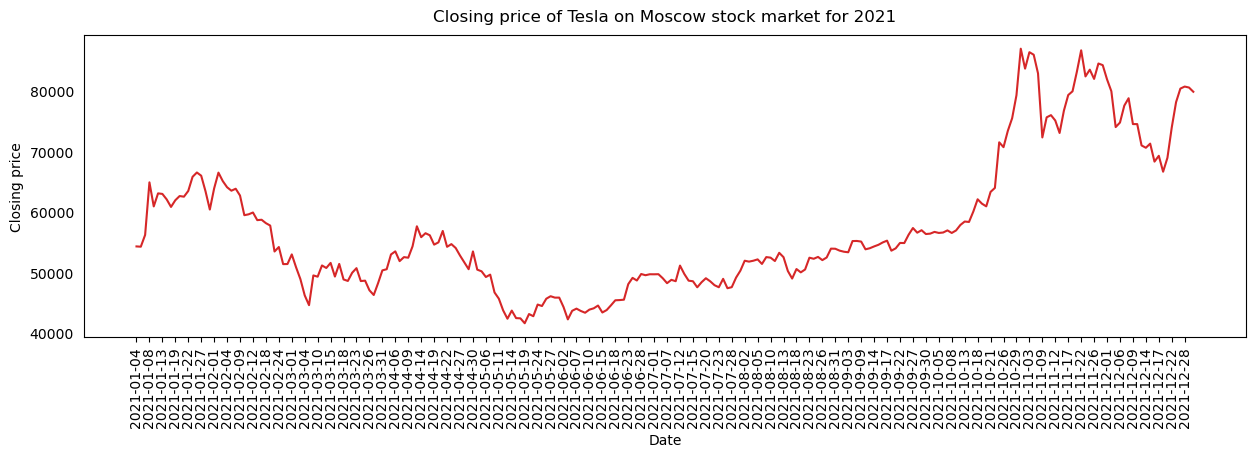

In [54]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Closing price', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.xticks(x[::3])
    plt.show()
    

plot_df(df, x=df['Date'], y=df['Closing price'], title='Closing price of Tesla on Moscow stock market for 2021')

Заметим, что тренд немонотоннен

Как видим есть повторяющийся паттерн в начале, думаю целесообразно взять ее период: 3 месяца или 90 дней(запись)

## Декомпозиция

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

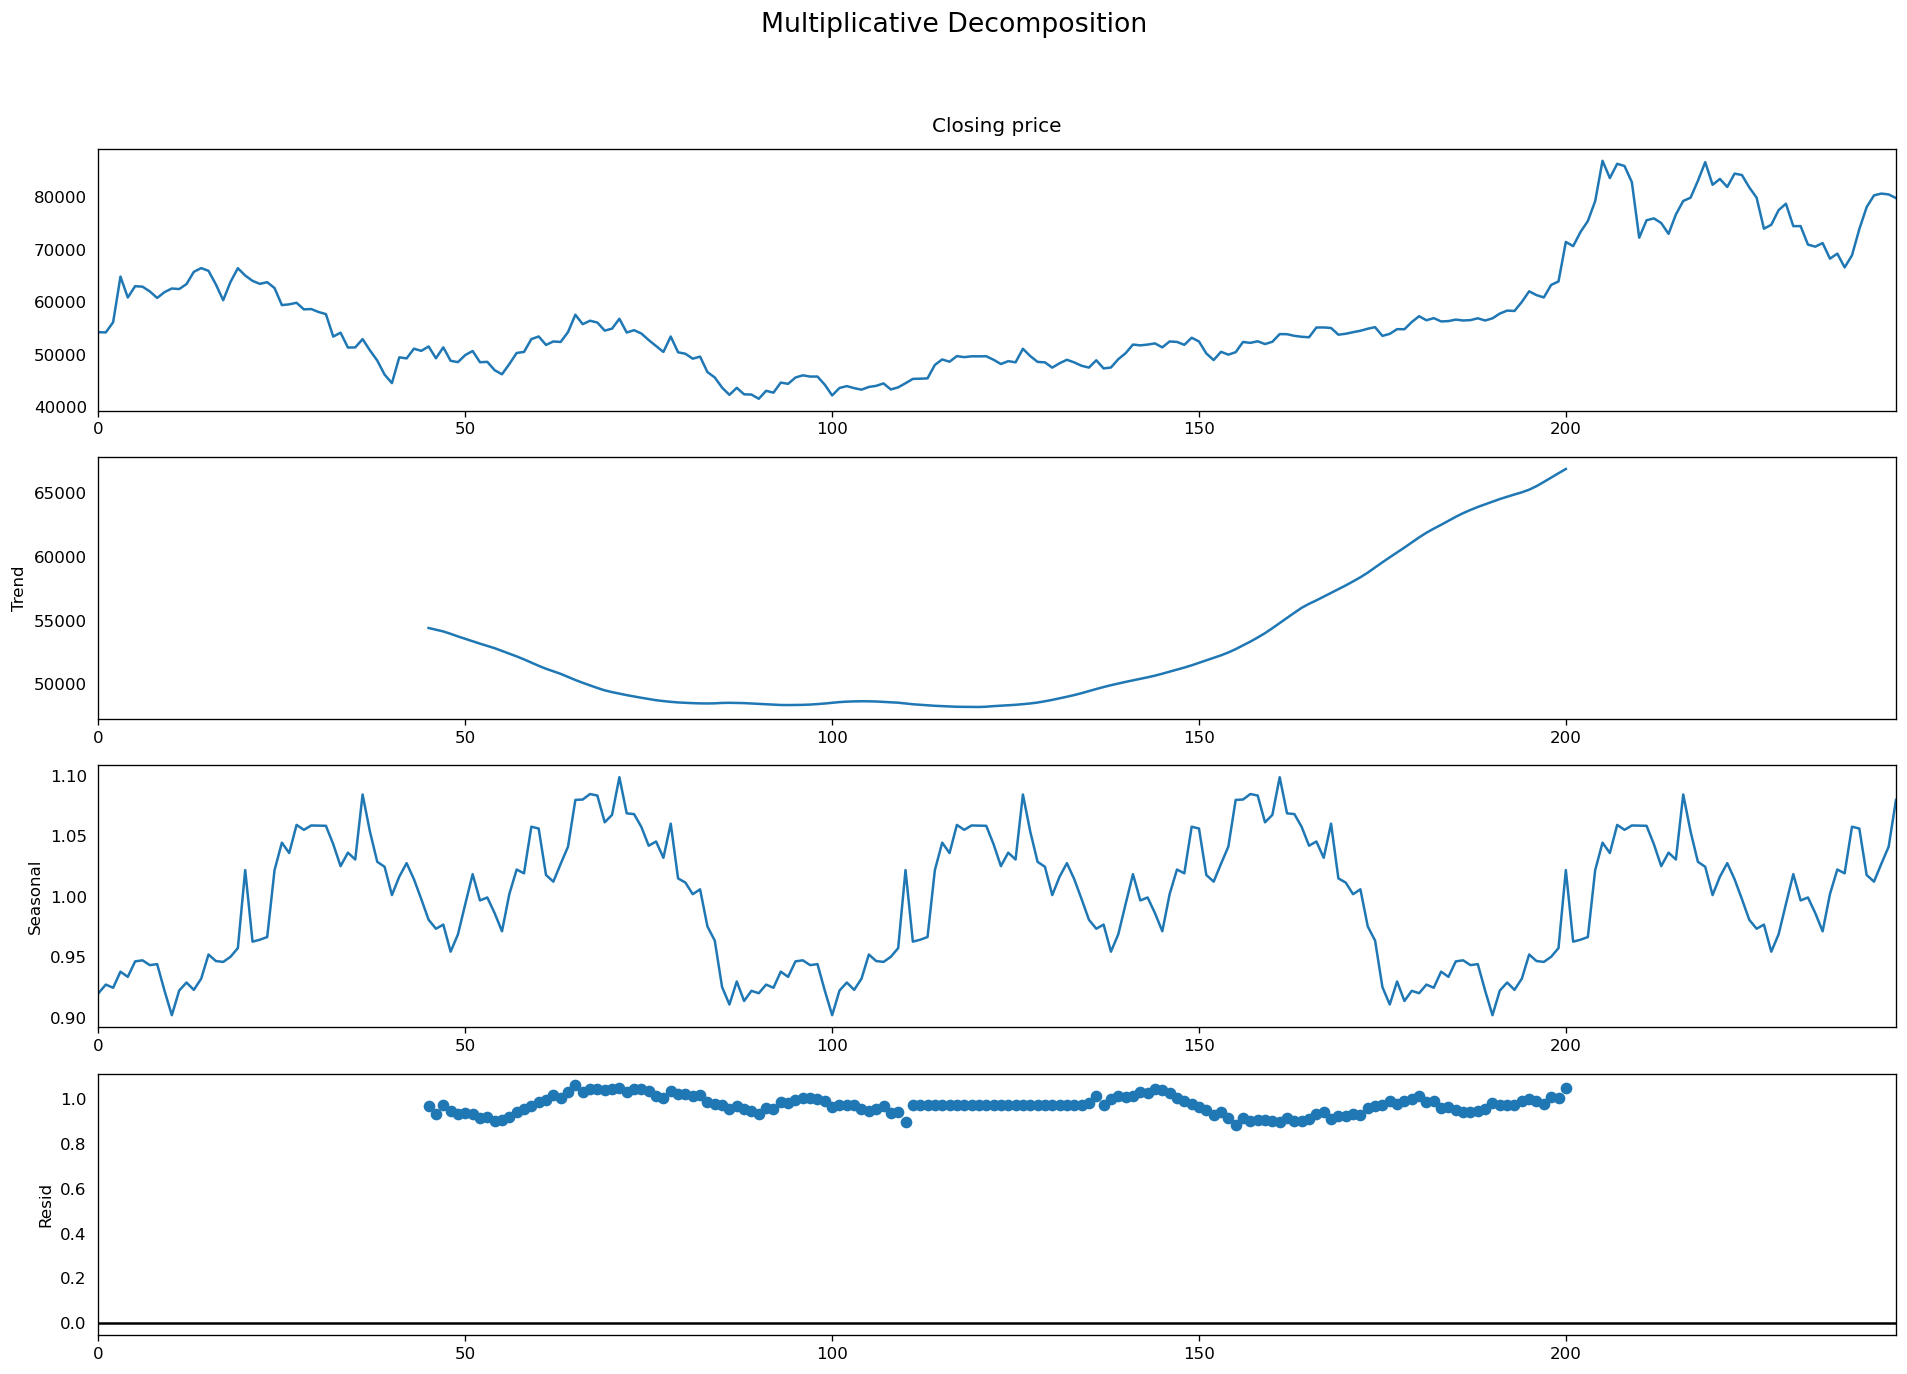

In [56]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df['Closing price'], model='multiplicative', period=90)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

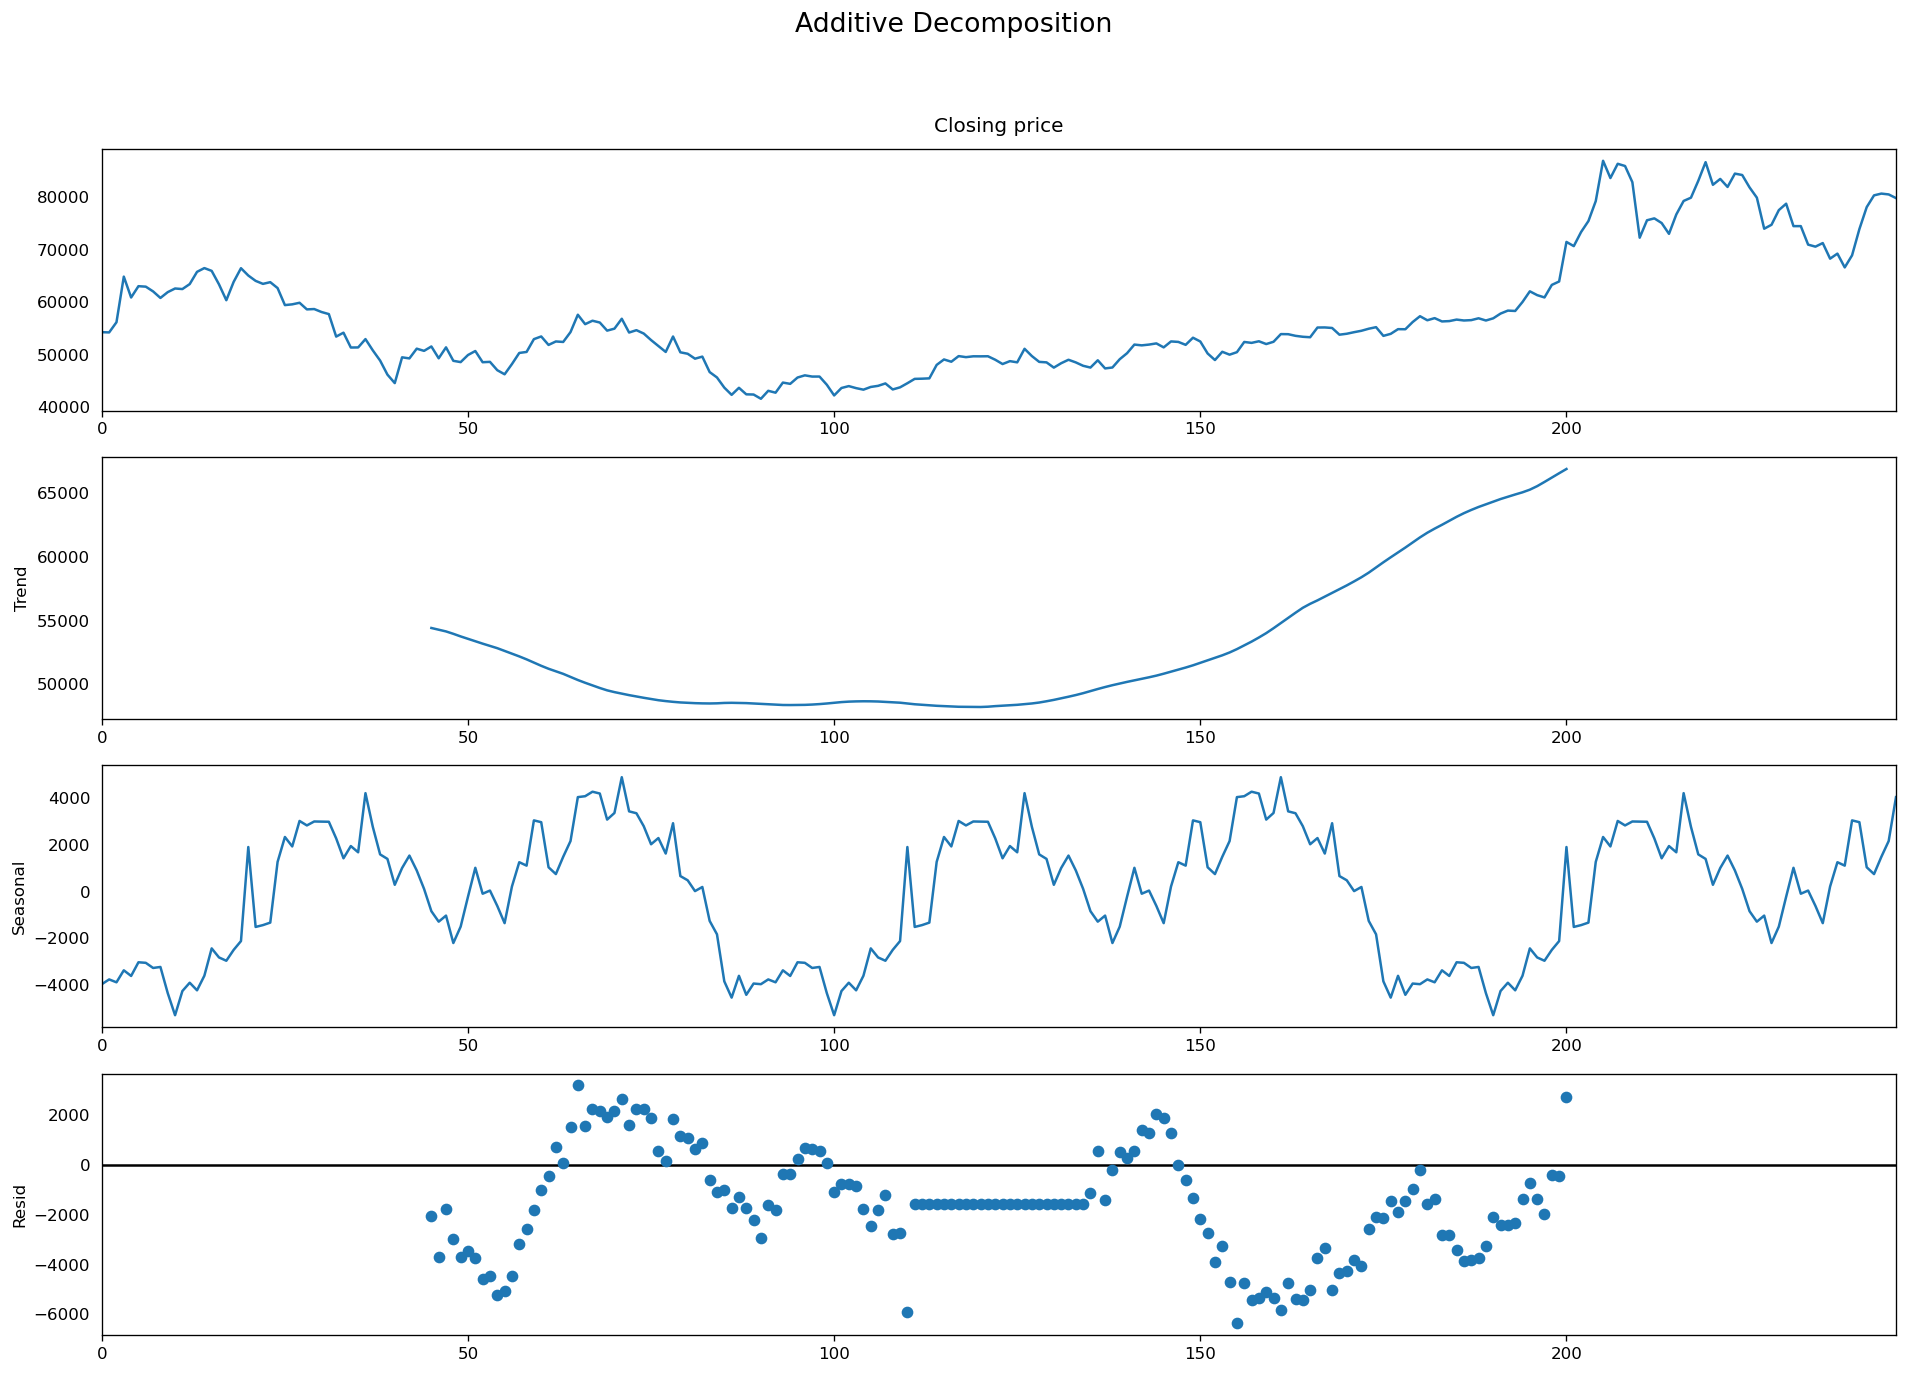

In [57]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(df['Closing price'], model='additive', period=90)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Если мы внимательно посмотрим на остатки аддитивного разложения, то увидим, что в нем сохранилась некоторая закономерность.

Мультипликативное разложение выглядит довольно случайным, что хорошо. Таким образом, в идеале мультипликативная декомпозиция должна быть предпочтительнее для этого конкретного ряда.

### Проверим на стационарность

На самом деле по графику видно, что ряд не является стационарным, но убедимся в этом явно с помощью kpss test

In [58]:
from statsmodels.tsa.stattools import adfuller

In [59]:
adfuller(df['Closing price'])

(-0.681135500116797,
 0.8515755476299766,
 0,
 245,
 {'1%': -3.4573260719088132,
  '5%': -2.873410402808354,
  '10%': -2.573095980841316},
 4123.749239427119)

p > 0.05 => ряд имеет единичный корень, отвергаем нулевую гипотезу, то есть ряд не стационарен

### Удалим тренд

Text(0.5, 1.0, 'Closing price detrended')

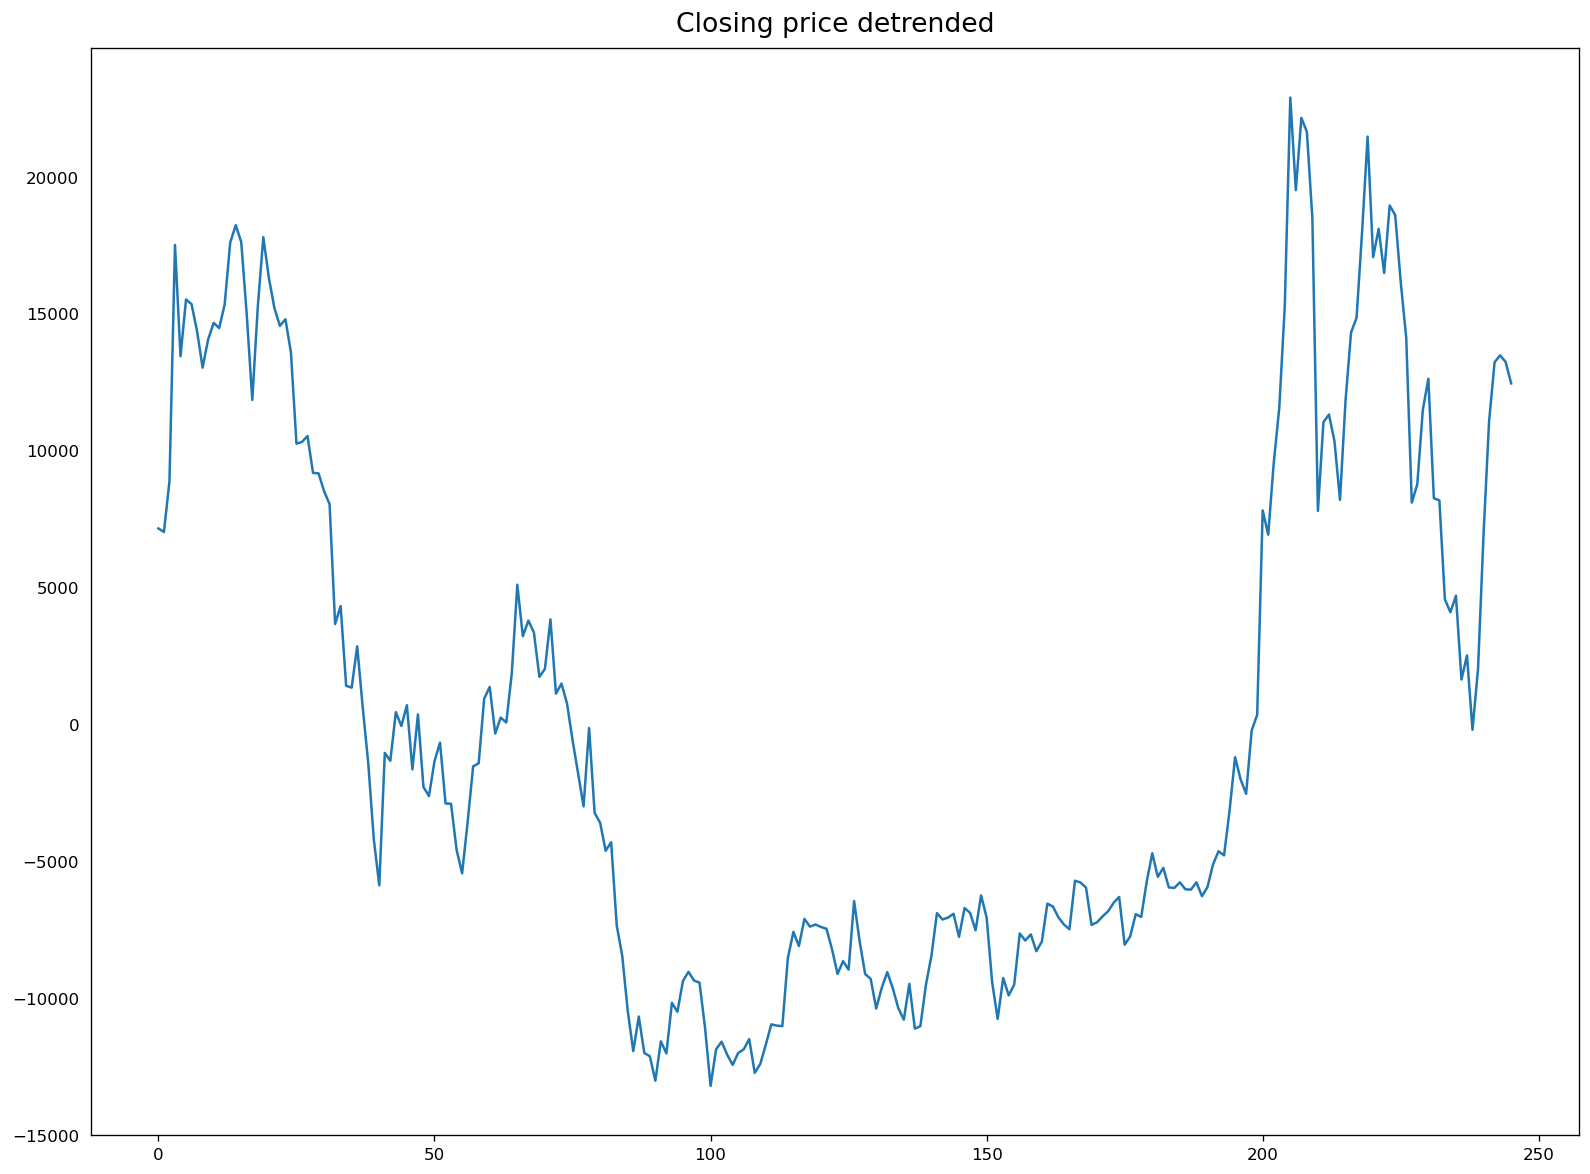

In [60]:
from scipy import signal
detrended = signal.detrend(df['Closing price'].values)
plt.plot(detrended)
plt.title('Closing price detrended', fontsize=16)

Сложно выделить какие-то циклы и сезонности во временном ряде, предпологаю это связано с тем, что взят маленький период в виде 1 года

### Deseasonalize

[]

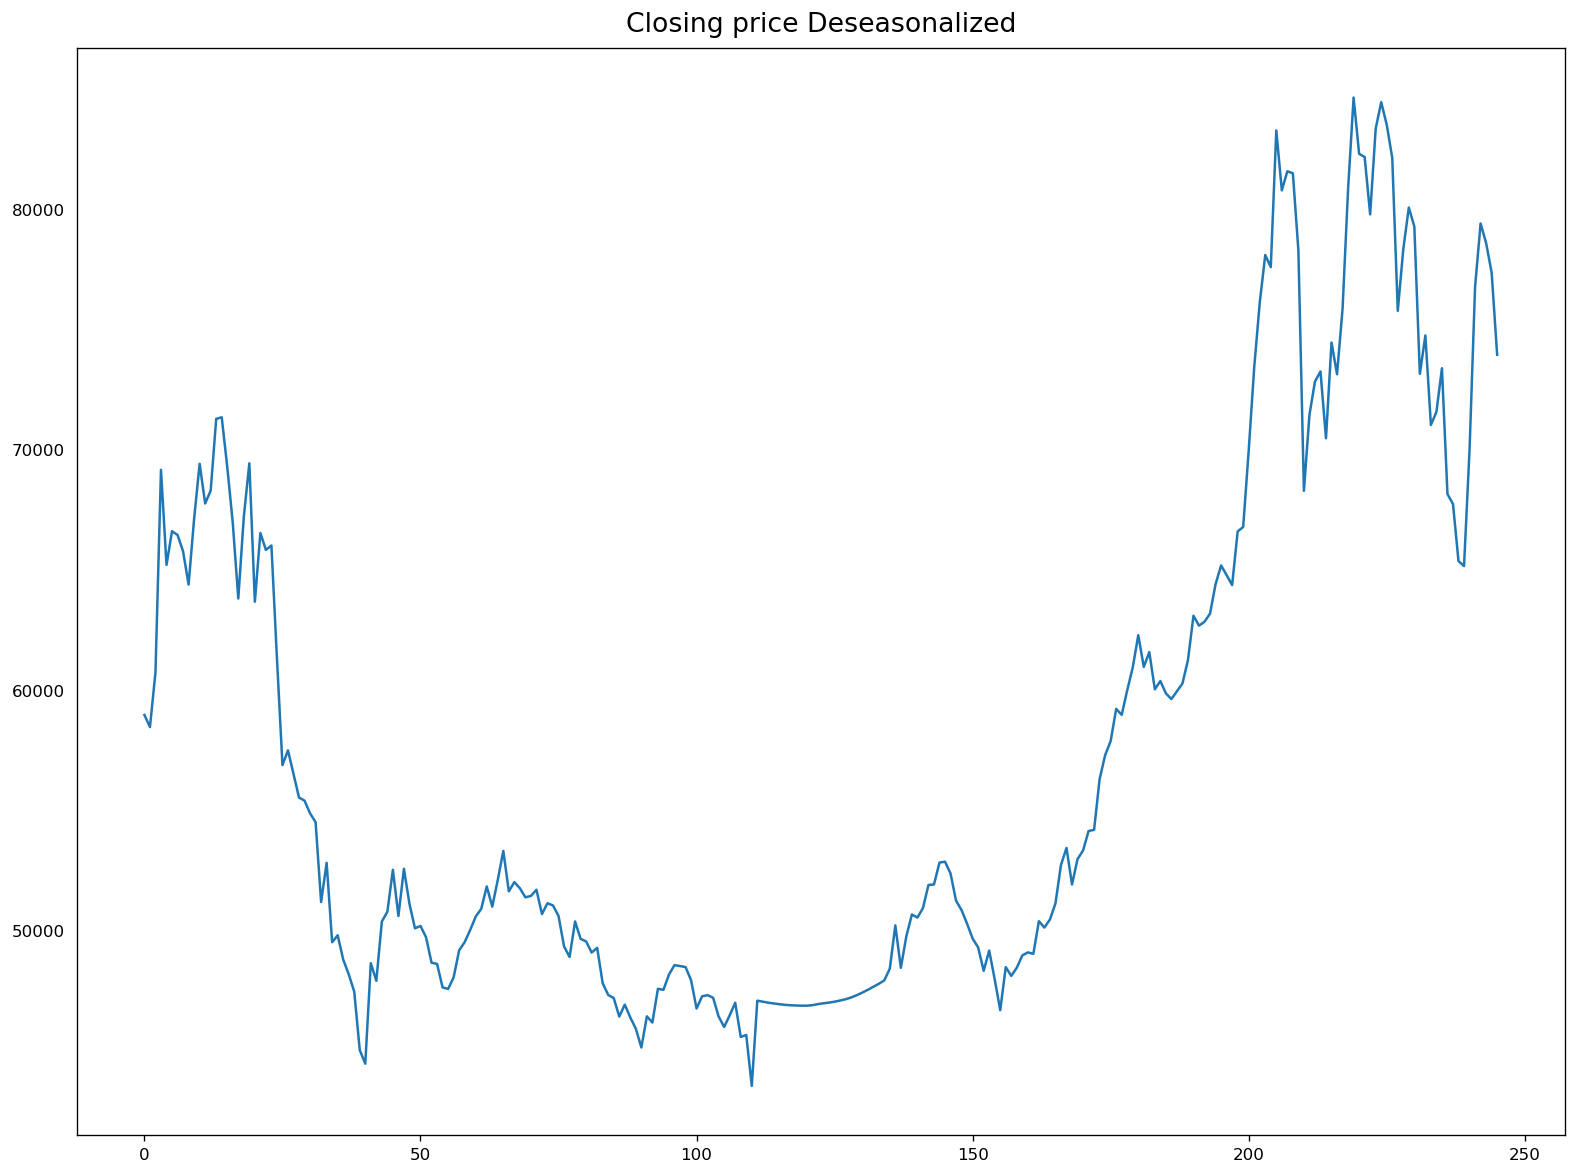

In [61]:
result_mul = seasonal_decompose(df['Closing price'], model='multiplicative', period=90)
deseasonalized = df['Closing price'].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Closing price Deseasonalized', fontsize=16)
plt.plot()

Ситуация аналогична

### Autocorrelation and Partial Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

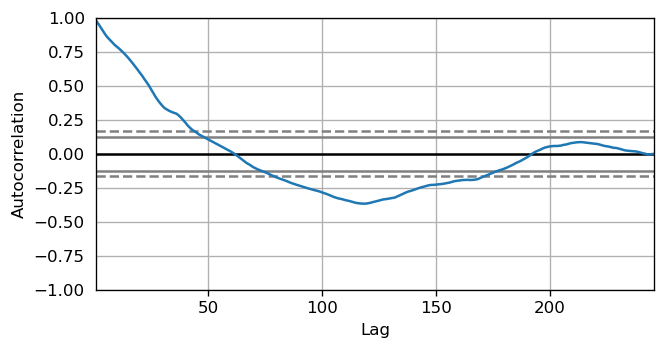

In [62]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})
autocorrelation_plot(df['Closing price'].tolist())

Большая корреляция на маленьких лагах

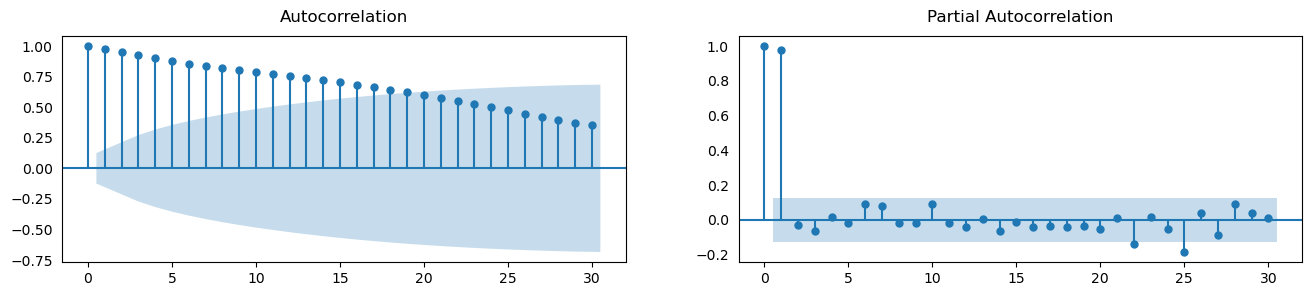

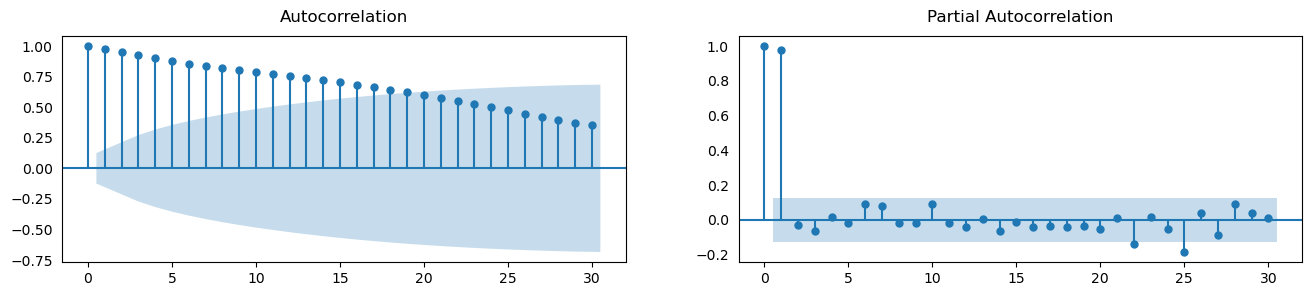

In [63]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Closing price'].tolist(), lags=30, ax=axes[0])
plot_pacf(df['Closing price'].tolist(), lags=30, ax=axes[1])

У 5 автокорреляция не очень низкая, так что можно попробовать предсказывать значение через неделю, зная текущее. А в 30 очень мала, значит сезонности по месяцам нет

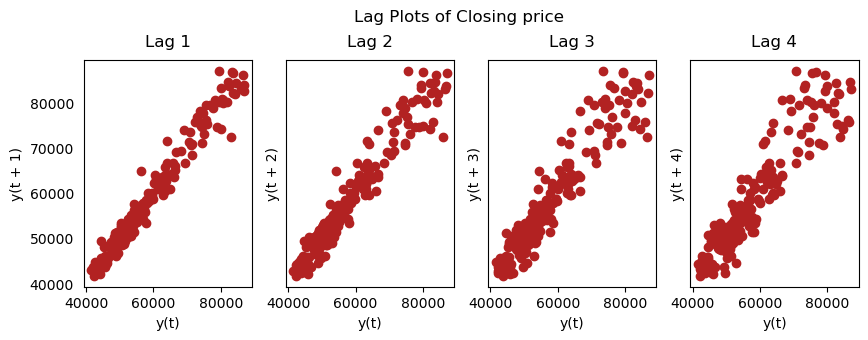

In [64]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['Closing price'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Closing price', y=1.05)    
plt.show()

Видим похожую картину: с увеличением лагов, растет разброс

#### Granger Causality Test

In [65]:
from statsmodels.tsa.stattools import grangercausalitytests
data = pd.read_csv('MOEX.TSLA-RM_FQBR_210101_211231.csv', sep=';')
data['day'] = np.arange(1, data.shape[0] + 1)
grangercausalitytests(data[['<CLOSE>', 'day']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7891  , p=0.0962  , df_denom=242, df_num=1
ssr based chi2 test:   chi2=2.8236  , p=0.0929  , df=1
likelihood ratio test: chi2=2.8075  , p=0.0938  , df=1
parameter F test:         F=2.7891  , p=0.0962  , df_denom=242, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3855  , p=0.2522  , df_denom=240, df_num=2
ssr based chi2 test:   chi2=2.8171  , p=0.2445  , df=2
likelihood ratio test: chi2=2.8010  , p=0.2465  , df=2
parameter F test:         F=1.7288  , p=0.1797  , df_denom=240, df_num=2


{1: ({'ssr_ftest': (2.7890511021229516, 0.0962033005335318, 242.0, 1),
   'ssr_chi2test': (2.8236261157856326, 0.09288634559370497, 1),
   'lrtest': (2.8074789098518522, 0.09382571981493885, 1),
   'params_ftest': (2.789051102122522, 0.09620330053355562, 242.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.3854683810770823, 0.2522003663161613, 240.0, 2),
   'ssr_chi2test': (2.8171190415234006, 0.24449521990192455, 2),
   'lrtest': (2.8009805193714783, 0.2464760970220701, 2),
   'params_ftest': (1.7288143699021106, 0.1796976844605618, 240.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

p > 0.05 => не можем отвергнуть нулевую гипотезу

### Прогнозирование

In [69]:
from prophet import Prophet

In [72]:
df_train = df.loc[df.Date < '2021-11-30']
df_train.columns = ['ds', 'y']
df_train.tail()

,ds,y
219,2021-11-22,86735.0
220,2021-11-23,82411.0
221,2021-11-24,83530.0
222,2021-11-26,82000.0
223,2021-11-29,84548.0


In [73]:
m = Prophet()
m.fit(df_train)

12:12:06 - cmdstanpy - INFO - Chain [1] start processing
12:12:06 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=31)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [74]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
249,2021-12-25
250,2021-12-26
251,2021-12-27
252,2021-12-28
253,2021-12-29


In [75]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
249,2021-12-25,93356.613231,84438.599431,94474.453204,92659.021940,94007.472861,-3633.554079,-3633.554079,-3633.554079,-3633.554079,-3633.554079,-3633.554079,0.0,0.0,0.0,89723.059152
250,2021-12-26,93772.193566,85393.031013,95462.658324,93034.650760,94461.677904,-3633.554426,-3633.554426,-3633.554426,-3633.554426,-3633.554426,-3633.554426,0.0,0.0,0.0,90138.639140
251,2021-12-27,94187.773900,90909.966873,101081.566941,93402.327395,94928.083032,1769.152494,1769.152494,1769.152494,1769.152494,1769.152494,1769.152494,0.0,0.0,0.0,95956.926394
252,2021-12-28,94603.354235,90940.578913,101396.796696,93768.381104,95397.525204,1426.408093,1426.408093,1426.408093,1426.408093,1426.408093,1426.408093,0.0,0.0,0.0,96029.762327
253,2021-12-29,95018.934569,91956.194834,101733.702921,94144.826113,95860.390417,1477.748698,1477.748698,1477.748698,1477.748698,1477.748698,1477.748698,0.0,0.0,0.0,96496.683267


In [76]:
pred = forecast.loc[forecast.ds > '2021-11-30',['ds', 'yhat']]
pred.head()

,ds,yhat
225,2021-12-01,84860.433902
226,2021-12-02,84890.675819
227,2021-12-03,85715.234814
228,2021-12-04,80995.872128
229,2021-12-05,81411.452116


In [77]:
df_test = df.loc[df.Date > '2021-11-30']
df_test.head()

,Date,Closing price
225,2021-12-01,81918.0
226,2021-12-02,79955.0
227,2021-12-03,74025.0
228,2021-12-06,74775.0
229,2021-12-07,77576.0


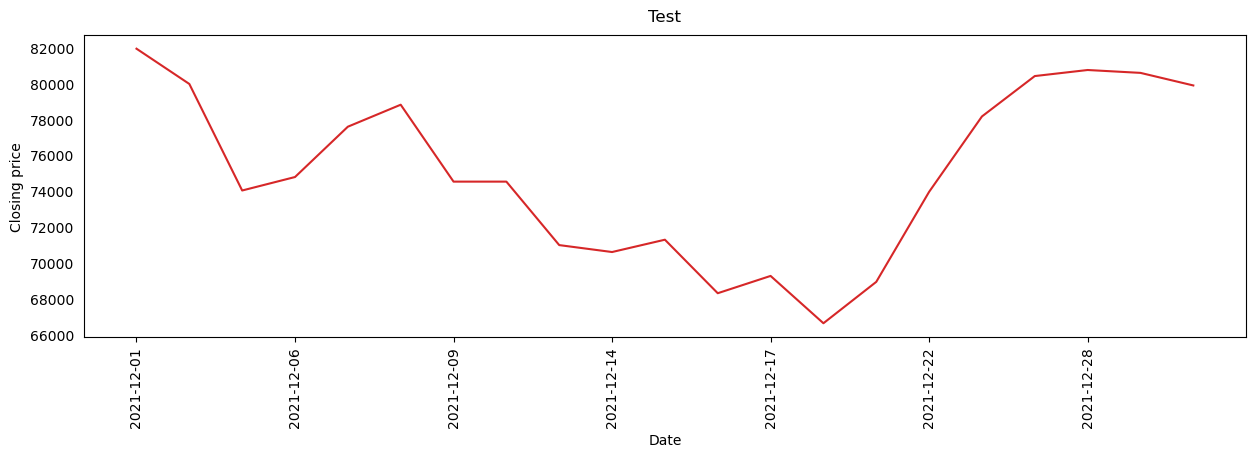

In [104]:
plot_df(df = df_test, x = df_test.Date, y = df_test['Closing price'], title = 'Test')

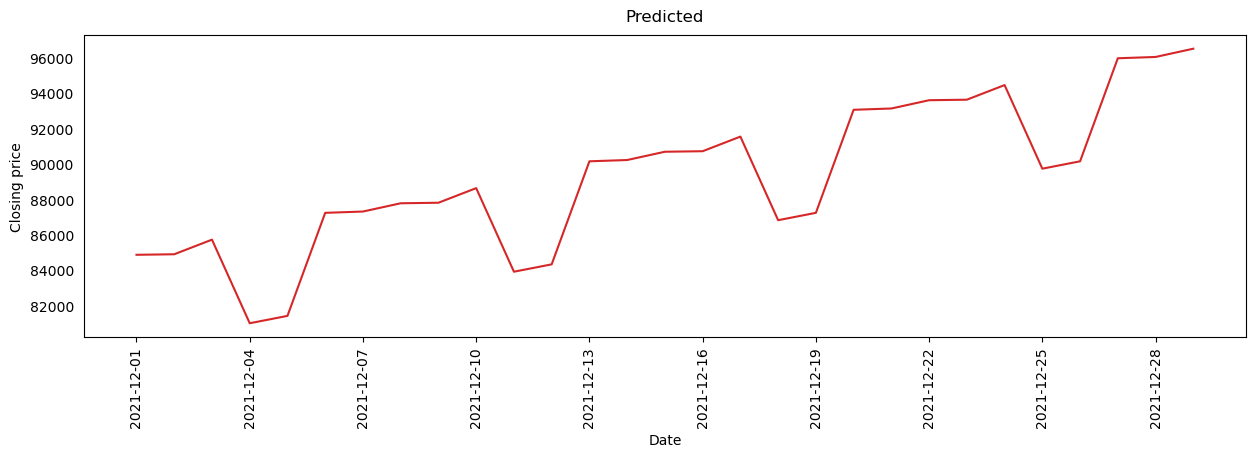

In [106]:
plot_df(df = pred, x = pred.ds, y = pred.yhat, title = 'Predicted')

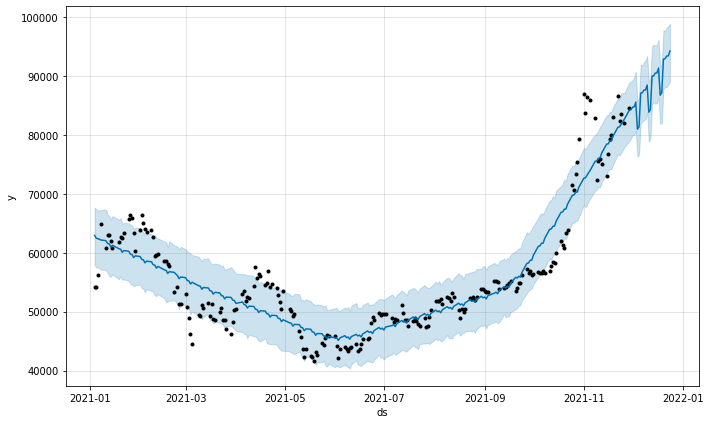

In [38]:
fig1 = m.plot(forecast)

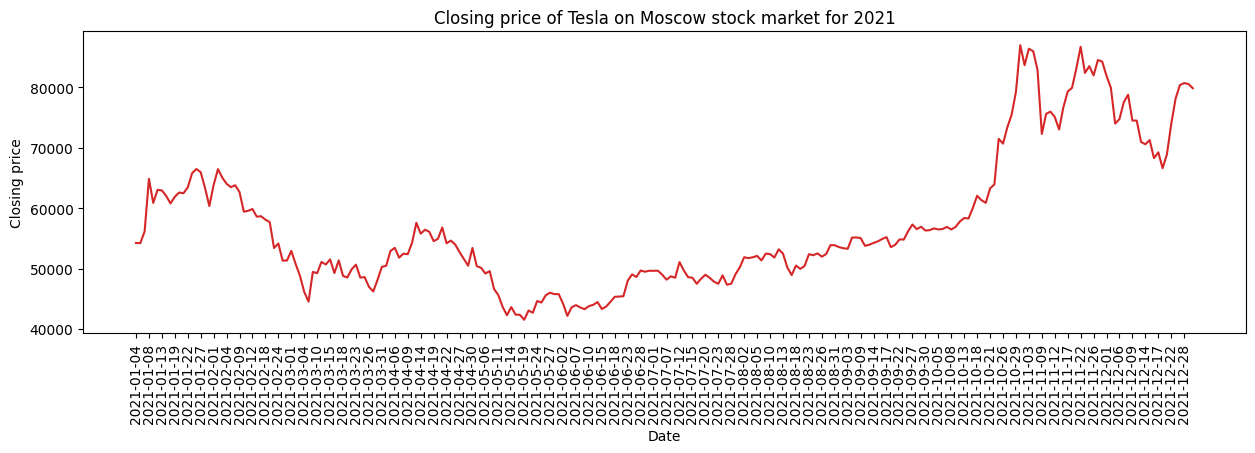

In [40]:
plot_df(df, x=df['ds'], y=df['y'], title='Closing price of Tesla on Moscow stock market for 2021')

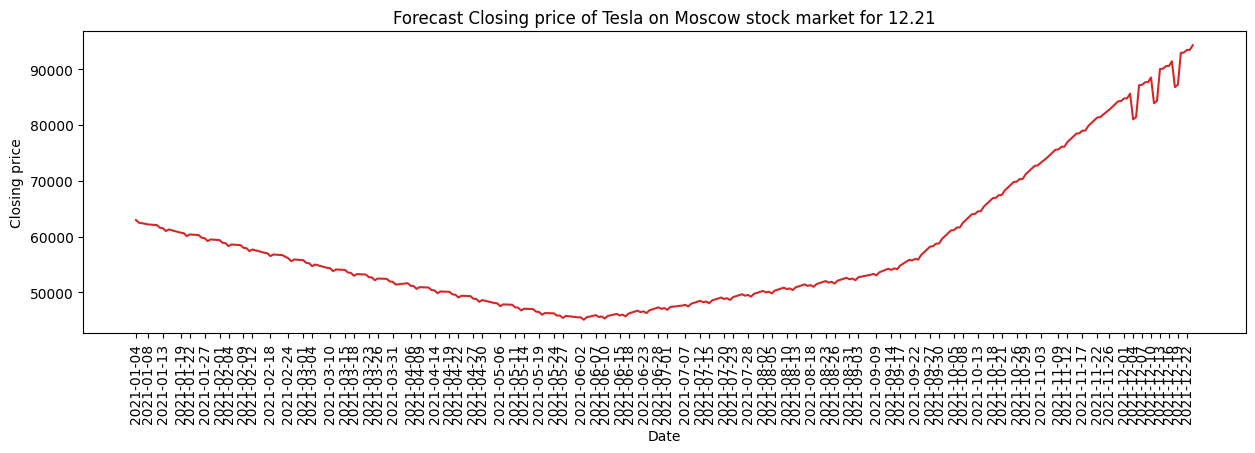

In [42]:
plot_df(df, x=forecast['ds'], y=forecast['yhat'], title='Forecast Closing price of Tesla on Moscow stock market for 12.21')

Модель уловила тренд, но также какую-то сезонность. Сложно интерпретировать данные результаты, ведь на цены акции влият очень много факторов